In [13]:
import dgl
import torch
import numpy as np
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
import dgl.function as fn
import dgl.nn.pytorch as dglnn
import itertools
from dgl.nn import GraphConv
from dgl.nn import SumPooling
from dgl.nn import DenseGraphConv
from dgl.nn import SAGEConv
import dgl.data

In [14]:
def create_line_graph(graph):
    graph = nx.line_graph(graph)
    node_mapper = {node: i for i, node in enumerate(graph.nodes())}
    edges = [[node_mapper[edge[0]], node_mapper[edge[1]]] for edge in graph.edges()]
    line_graph = nx.from_edgelist(edges)
    return line_graph 

In [15]:
def visualize(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(18, 18))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=30, cmap=plt.get_cmap('coolwarm'), # node_color=labels, 
                     edge_color='k', arrows=True, width=0.7, style='dotted', with_labels=False)

# Test Line Graph

In [16]:
edges = [
        ['7', '6'],
        ['6', '5'],
        ['5', '4'],
        ['5', '2'],
        ['4', '3'],
        ['2', '1'],
        ['2', '3'],
        ['3', '1'],
    ]

G = nx.Graph()
G.add_edges_from(edges)

In [17]:
LG = create_line_graph(G)
LnxG = nx.line_graph(G)

In [18]:
print(G.is_directed())
print(LG.is_directed())
print(LnxG.is_directed())

False
False
False


In [19]:
print(G.number_of_nodes(), G.number_of_edges())
print(LG.number_of_nodes(), LG.number_of_edges())
print(LnxG.number_of_nodes(), LnxG.number_of_edges())

7 8
8 12
8 12


In [20]:
LnxG.nodes()

NodeView((('6', '7'), ('1', '2'), ('1', '3'), ('2', '3'), ('3', '4'), ('2', '5'), ('4', '5'), ('5', '6')))

In [21]:
LnxG.edges()

EdgeView([(('6', '7'), ('5', '6')), (('1', '2'), ('1', '3')), (('1', '2'), ('2', '3')), (('1', '2'), ('2', '5')), (('1', '3'), ('3', '4')), (('1', '3'), ('2', '3')), (('2', '3'), ('3', '4')), (('2', '3'), ('2', '5')), (('3', '4'), ('4', '5')), (('2', '5'), ('5', '6')), (('2', '5'), ('4', '5')), (('4', '5'), ('5', '6'))])

In [22]:
dual_g = dgl.from_networkx(LnxG)

In [23]:
print(len(list(dual_g.nodes())), list(dual_g.nodes()))
print(len(list(dual_g.edges())[0]))
list(dual_g.edges())

8 [tensor(0), tensor(1), tensor(2), tensor(3), tensor(4), tensor(5), tensor(6), tensor(7)]
24


[tensor([7, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 4, 4, 4, 3, 3, 3, 3, 5, 5, 5, 6, 6, 6]),
 tensor([6, 1, 2, 3, 0, 4, 2, 0, 1, 4, 3, 1, 2, 5, 0, 2, 6, 5, 4, 3, 6, 7, 3, 5])]

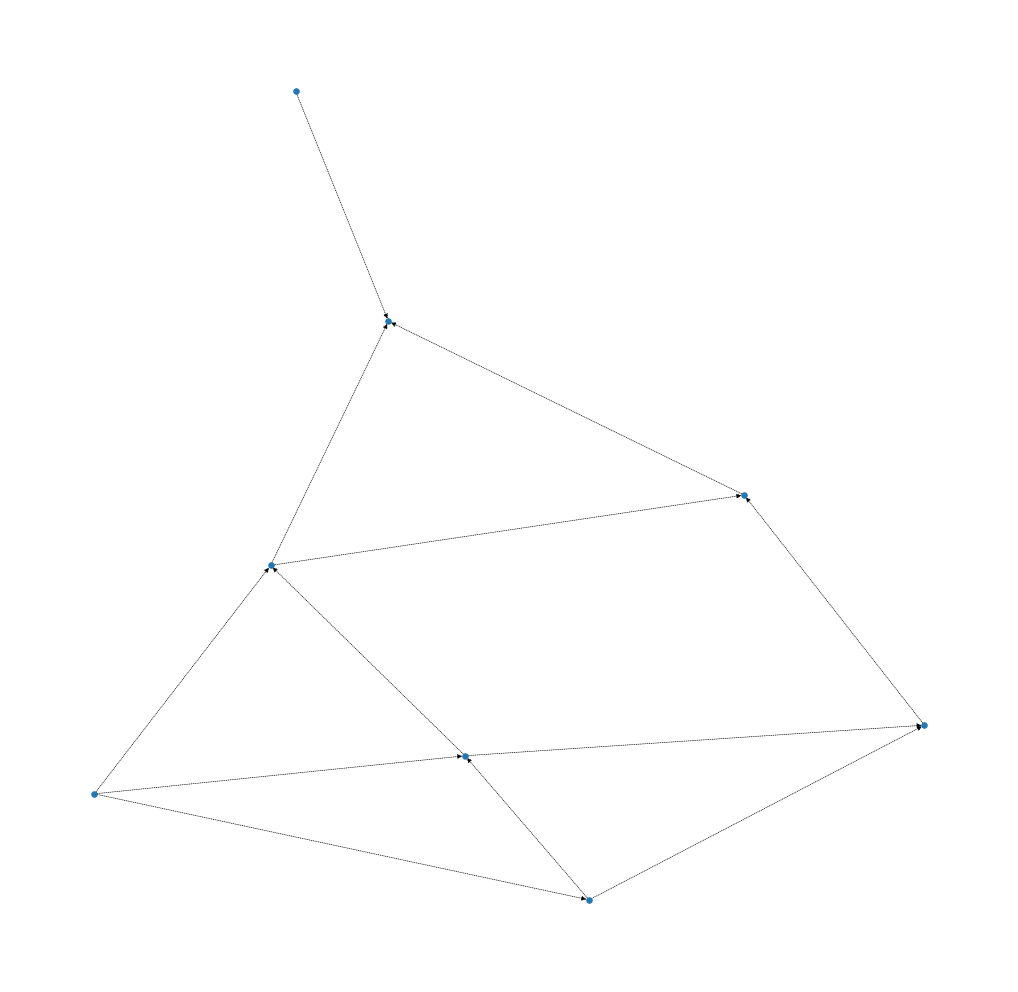

In [24]:
label = ['r','b','b','b','b','b','b','b']#g.ndata['label']
#nx_G1 = g.to_networkx()
    
visualize(label, LnxG)

In [11]:
node2vec = Node2Vec(G)
model = node2vec.fit(window=10, min_count=1)
embeddings = np.array([model.wv[x] for x in list(G.nodes)])

Computing transition probabilities:   0%|          | 0/7 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 571.72it/s]


In [12]:
print(list(G.nodes)[:10])
print(len(node2vec.walks))
print(len(list(node2vec.walks[0])), list(node2vec.walks[0]))

['7', '6', '5', '4', '2', '3', '1']
70
80 ['7', '6', '5', '2', '3', '1', '2', '3', '4', '3', '2', '3', '4', '3', '1', '2', '5', '2', '3', '1', '3', '2', '1', '3', '4', '5', '4', '5', '6', '7', '6', '5', '6', '5', '4', '3', '1', '2', '1', '3', '4', '3', '4', '3', '1', '3', '1', '3', '1', '2', '3', '4', '3', '4', '3', '4', '3', '4', '3', '4', '5', '6', '5', '6', '7', '6', '5', '4', '3', '1', '2', '1', '3', '4', '5', '4', '5', '6', '5', '4']


In [15]:
len(model.wv[7])

KeyError: "Key '7' not present"

In [47]:
embeddings[0]

tensor([-0.3562,  0.0719,  0.6468,  1.1467, -0.2215, -1.2640, -0.6763, -0.3687,
        -0.2149, -0.0021,  0.1709, -0.1408,  0.2707, -0.7397, -0.8067, -0.1142,
        -0.5443,  0.3135, -0.9498, -0.0451, -0.3072, -0.1428,  1.1048, -0.0320,
        -0.4650, -0.3227, -0.2037,  0.1510,  0.3425,  0.2850, -0.0886,  0.6421,
         0.4755,  0.6475,  0.2516,  0.0088, -0.0652,  0.1911,  0.1721, -0.1007,
         0.5439,  1.0305, -0.0793,  0.1415, -0.5288,  0.0169, -0.6118, -0.4543,
         0.0310,  0.3839, -0.0662,  0.1455,  0.3521, -0.0699, -0.0243, -0.1893,
        -0.4268, -0.6015,  0.3345,  0.2923,  0.5955, -0.0544,  0.0790,  0.0937,
         0.4152, -0.6046,  0.5586,  0.3394, -0.0377,  0.1372, -0.2169,  0.6447,
        -0.4213,  0.7282,  0.5632, -0.7520,  0.7666,  0.6520, -0.6648, -0.0121,
        -0.1924, -0.0465, -0.3198,  0.3609,  0.7441, -0.2645,  0.0722, -0.9286,
         0.1259,  0.4971,  0.3305,  0.6858, -0.5329, -0.6132,  0.1821,  0.1690,
        -0.0883,  0.2584,  0.0033,  0.18

#################################################################################################################################################

In [25]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [27]:
def positive_sample(graph, test_size=0.1):
    u, v = graph.edges()
    eids = np.random.permutation(np.arange(graph.number_of_edges())) #random index edges
    test_size_idx = int(len(eids) * test_size) #size positive sample by index

    test_pos_u, test_pos_v = u[eids[:test_size_idx]], v[eids[:test_size_idx]]
    train_pos_u, train_pos_v = u[eids[test_size_idx:]], v[eids[test_size_idx:]] 
    
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=graph.number_of_nodes())
    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=graph.number_of_nodes())
    
    return train_pos_g, test_pos_g

In [28]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
G = g.to_networkx()
print(len(list(G.nodes())))
print(len(list(G.edges())))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
2708
10556


In [29]:
def negative_sample(graph, method='kneighbors', size=g.number_of_nodes(), test_size=int(g.number_of_edges()*0.1)):   
    new_g = graph.to_networkx()
    adj = nx.to_numpy_array(new_g) #adjacency matrix
    
    if method == 'dgl_example':
        adj_neg = 1 - adj - np.eye(graph.number_of_nodes())
        neg_u, neg_v = np.where(adj_neg != 0)
        neg_eids = np.random.choice(len(neg_u), graph.number_of_edges() // 2) #negative sample random index
        
        test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
        train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
    
    else:
        negs_u = []
        negs_v = []
        negs = []
        nnn = NearestNeighbors(n_neighbors=500, metric='cosine')
        nnn.fit(adj)
        res = nnn.kneighbors(return_distance=False) #top-5 nearest neightbord

        for idx, i in enumerate(res):
            for j in i:
                if not new_g.has_edge(idx, j):
                    negs.append([idx, j])

        negs = np.array(negs)

        for k in range(size):
            temp = negs[np.random.permutation(negs.shape[0])[:graph.number_of_edges()]][0]
            negs_u.append(temp[0])
            negs_v.append(temp[1])
            
        test_neg_u, test_neg_v = negs_u[:test_size], negs_v[:test_size]
        train_neg_u, train_neg_v = negs_u[test_size:], negs_v[test_size:]
    
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=graph.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=graph.number_of_nodes())
            
    return train_neg_g, test_neg_g

In [31]:
node2vec = Node2Vec(G)
model_n2v = node2vec.fit(window=10, min_count=1)
embeddings = np.array([model_n2v.wv[x] for x in list(G.nodes)])
embeddings = torch.from_numpy(embeddings)
g.ndata['feat'] = embeddings

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


In [32]:
eids = np.random.permutation(np.arange(g.number_of_edges()))
train_g = dgl.remove_edges(g, eids[:int(len(eids) * 0.1)]) #subgraph
print(train_g)

Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={'feat': Scheme(shape=(128,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [30]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])    
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [26]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [33]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 20)
#model = SAGE(train_g.ndata['feat'].shape[1], 20, 4, F.relu, 0.25)
#pred = DotPredictor()
pred = MLPPredictor(20)

In [34]:
train_pos_g, test_pos_g = positive_sample(g)
train_neg_g, test_neg_g = negative_sample(g, 'dgl_example')

In [47]:
print(list(pred.parameters())[0].shape)
print(list(pred.parameters())[1].shape)
print(list(pred.parameters())[2].shape)
print(list(pred.parameters())[3].shape)

torch.Size([20, 40])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


In [51]:
list(pred.parameters())

[Parameter containing:
 tensor([[ 0.2091,  0.2631, -0.1109,  0.1888, -0.1938, -0.0542,  0.0606,  0.1295,
          -0.1189,  0.1355, -0.1314, -0.1239,  0.2225, -0.0455,  0.0062, -0.0411,
           0.1557, -0.1570, -0.0454, -0.2034,  0.1231,  0.2268,  0.0600,  0.0706,
          -0.0872, -0.1695,  0.0367,  0.2364,  0.1668, -0.0405, -0.0432, -0.0054,
           0.1927, -0.2519,  0.0144, -0.0519,  0.0412,  0.1169,  0.1710, -0.1632],
         [-0.2796, -0.0355, -0.3719, -0.0170,  0.3627,  0.0163, -0.1131, -0.0149,
          -0.2587, -0.0535, -0.0042, -0.2348, -0.0394, -0.5846, -0.2425,  0.0146,
          -0.1041,  0.1820, -0.1338, -0.0346, -0.0587, -0.0518,  0.4558, -0.0046,
          -0.1444,  0.0981,  0.3998,  0.0786,  0.4083,  0.0058,  0.2411, -0.3544,
           0.0598,  0.0921, -0.1139,  0.4357, -0.2005, -0.3409,  0.1566,  0.2357],
         [-0.1028,  0.0579, -0.0948, -0.1165, -0.1519, -0.1007,  0.0476,  0.0913,
          -0.0616, -0.0045,  0.1567, -0.0313, -0.1341,  0.1159, -0.1508, 

In [54]:
#optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
optimizer = torch.optim.Adam(pred.parameters(), lr=0.01)

all_logits = []
for e in range(100):
    model.eval()
    h = model(train_g, embeddings)  #train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))


from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.18581295013427734
In epoch 5, loss: 0.20346185564994812
In epoch 10, loss: 0.185930073261261
In epoch 15, loss: 0.18419614434242249
In epoch 20, loss: 0.18501344323158264
In epoch 25, loss: 0.18326669931411743
In epoch 30, loss: 0.1809893101453781
In epoch 35, loss: 0.1806168258190155
In epoch 40, loss: 0.17974503338336945
In epoch 45, loss: 0.17879442870616913
In epoch 50, loss: 0.1781412810087204
In epoch 55, loss: 0.17743074893951416
In epoch 60, loss: 0.17675545811653137
In epoch 65, loss: 0.1761402040719986
In epoch 70, loss: 0.17550881206989288
In epoch 75, loss: 0.1748753935098648
In epoch 80, loss: 0.1742769032716751
In epoch 85, loss: 0.17370642721652985
In epoch 90, loss: 0.1731530725955963
In epoch 95, loss: 0.17259767651557922
AUC 0.9031872599447452


# LP Task with line Graph 

In [32]:
temp_G = nx.DiGraph()
temp_G.add_edges_from(list(G.edges()))
print(len(list(temp_G.nodes())))
print(len(list(temp_G.edges())))

2708
10556


In [33]:
LnxG = nx.line_graph(temp_G)
dual_g = dgl.from_networkx(LnxG)

In [34]:
print(len(list(LnxG.nodes())))
list(LnxG.nodes())[:5]

10556


[(0, 633), (633, 0), (633, 1701), (633, 1866), (0, 1862)]

In [35]:
len(list(LnxG.edges()))

115158

In [84]:
def alternate_list(a,b):
    c = list()
    for x in range(len(a)):
        c.extend([a[x], b[x]])
    return c

In [138]:
m = nn.AvgPool1d(2, stride=2)
#node2vec = Node2Vec(LnxG)
#model_n2v = node2vec.fit(window=10, min_count=1)
embeddings = [[alternate_list(model_n2v.wv[x][0],model_n2v.wv[x][1]) for x in list(LnxG.nodes)]]
embeddings = m(torch.tensor(embeddings))[0]
# embeddings = torch.from_numpy(np.reshape(embeddings.flatten(),(10556,256)))
dual_g.ndata['feat'] = embeddings

In [37]:
dual_eids = np.random.permutation(np.arange(dual_g.number_of_edges()))
train_dual_g = dgl.remove_edges(dual_g, eids[:int(len(dual_eids) * 0.1)]) #subgraph
print(train_dual_g)

Graph(num_nodes=10556, num_edges=104602,
      ndata_schemes={'feat': Scheme(shape=(256,), dtype=torch.float32)}
      edata_schemes={})


In [38]:
model = GraphSAGE(train_dual_g.ndata['feat'].shape[1], 20)
#model = SAGE(train_g.ndata['feat'].shape[1], 20, 4, F.relu, 0.25)
#pred = DotPredictor()
pred = MLPPredictor(20)

In [39]:
train_pos_g, test_pos_g = positive_sample(dual_g)
train_neg_g, test_neg_g = negative_sample(dual_g, 'dgl_example')

In [40]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    h = model(train_dual_g, embeddings)  #train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))


from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.706829845905304
In epoch 5, loss: 0.6571868062019348
In epoch 10, loss: 0.6407327055931091
In epoch 15, loss: 0.6243399381637573
In epoch 20, loss: 0.6006797552108765
In epoch 25, loss: 0.5711714625358582
In epoch 30, loss: 0.546612560749054
In epoch 35, loss: 0.5299765467643738
In epoch 40, loss: 0.5167433023452759
In epoch 45, loss: 0.5066409111022949
In epoch 50, loss: 0.4984222650527954
In epoch 55, loss: 0.49076011776924133
In epoch 60, loss: 0.48473072052001953
In epoch 65, loss: 0.48049843311309814
In epoch 70, loss: 0.4720494747161865
In epoch 75, loss: 0.4649830758571625
In epoch 80, loss: 0.4580879807472229
In epoch 85, loss: 0.44973331689834595
In epoch 90, loss: 0.44106853008270264
In epoch 95, loss: 0.4309082329273224
AUC 0.8564272029271526


In [42]:
list(LnxG.nodes)[:5]

[(0, 633), (633, 0), (633, 1701), (633, 1866), (0, 1862)]

In [43]:
model_n2v.wv[(0, 633)]

array([[-0.3561999 ,  0.07185076,  0.64677095,  1.1466671 , -0.22148785,
        -1.2639918 , -0.67631733, -0.3686724 , -0.21487173, -0.00211923,
         0.1709498 , -0.14078696,  0.27068004, -0.73967564, -0.80667037,
        -0.11416445, -0.5443083 ,  0.3135143 , -0.94982415, -0.0451231 ,
        -0.30718407, -0.14284241,  1.1047883 , -0.03200176, -0.46497816,
        -0.32271215, -0.20371759,  0.15103401,  0.3425304 ,  0.28504324,
        -0.08860509,  0.64210296,  0.4754786 ,  0.64752066,  0.25161168,
         0.00880363, -0.0652345 ,  0.19110148,  0.17214754, -0.1007219 ,
         0.54392064,  1.0304666 , -0.07931601,  0.1414947 , -0.52883375,
         0.01687058, -0.6117683 , -0.4542856 ,  0.03097405,  0.3839137 ,
        -0.06619526,  0.14554574,  0.35213888, -0.06990024, -0.02426645,
        -0.18932559, -0.42681122, -0.6014553 ,  0.33449978,  0.2922842 ,
         0.5954542 , -0.05438709,  0.07901666,  0.09365355,  0.41520372,
        -0.6046495 ,  0.5585892 ,  0.3393644 , -0.0

In [44]:
model_n2v.wv[0]

array([-0.3561999 ,  0.07185076,  0.64677095,  1.1466671 , -0.22148785,
       -1.2639918 , -0.67631733, -0.3686724 , -0.21487173, -0.00211923,
        0.1709498 , -0.14078696,  0.27068004, -0.73967564, -0.80667037,
       -0.11416445, -0.5443083 ,  0.3135143 , -0.94982415, -0.0451231 ,
       -0.30718407, -0.14284241,  1.1047883 , -0.03200176, -0.46497816,
       -0.32271215, -0.20371759,  0.15103401,  0.3425304 ,  0.28504324,
       -0.08860509,  0.64210296,  0.4754786 ,  0.64752066,  0.25161168,
        0.00880363, -0.0652345 ,  0.19110148,  0.17214754, -0.1007219 ,
        0.54392064,  1.0304666 , -0.07931601,  0.1414947 , -0.52883375,
        0.01687058, -0.6117683 , -0.4542856 ,  0.03097405,  0.3839137 ,
       -0.06619526,  0.14554574,  0.35213888, -0.06990024, -0.02426645,
       -0.18932559, -0.42681122, -0.6014553 ,  0.33449978,  0.2922842 ,
        0.5954542 , -0.05438709,  0.07901666,  0.09365355,  0.41520372,
       -0.6046495 ,  0.5585892 ,  0.3393644 , -0.0377478 ,  0.13

In [46]:
node2vec.walks[0]

['(1564, 1786)',
 '(1786, 18)',
 '(18, 1786)',
 '(1786, 1564)',
 '(1564, 1786)',
 '(1786, 1624)',
 '(1624, 409)',
 '(409, 407)',
 '(407, 695)',
 '(695, 1682)',
 '(1682, 2320)',
 '(2320, 1682)',
 '(1682, 2319)',
 '(2319, 1682)',
 '(1682, 2291)',
 '(2291, 377)',
 '(377, 1265)',
 '(1265, 377)',
 '(377, 733)',
 '(733, 2301)',
 '(2301, 2008)',
 '(2008, 733)',
 '(733, 2303)',
 '(2303, 2541)',
 '(2541, 1591)',
 '(1591, 2541)',
 '(2541, 1591)',
 '(1591, 2541)',
 '(2541, 2303)',
 '(2303, 733)',
 '(733, 2301)',
 '(2301, 733)',
 '(733, 1329)',
 '(1329, 733)',
 '(733, 218)',
 '(218, 781)',
 '(781, 218)',
 '(218, 2594)',
 '(2594, 218)',
 '(218, 482)',
 '(482, 2230)',
 '(2230, 938)',
 '(938, 2230)',
 '(2230, 938)',
 '(938, 2230)',
 '(2230, 938)',
 '(938, 618)',
 '(618, 938)',
 '(938, 618)',
 '(618, 938)',
 '(938, 2230)',
 '(2230, 482)',
 '(482, 2230)',
 '(2230, 938)',
 '(938, 2230)',
 '(2230, 606)',
 '(606, 27)',
 '(27, 606)',
 '(606, 27)',
 '(27, 606)',
 '(606, 1666)',
 '(1666, 49)',
 '(49, 2034)',

In [ ]:
train_g = dgl.remove_edges(g, eids[:1000], ) #subgraph
train_g = dgl.remove_nodes(train_g, range(2000))
print(train_g)

label2 = train_g.ndata['label']
nx_G2 = train_g.to_networkx()

#visualize(label2, nx_G2)

# TRASH

In [ ]:
'''
data_dir = os.path.expanduser("~/data/cora")

data_dir
#edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])

edgelist = pd.read_csv(f"./data/cora/cora.cites", sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

edgelist.sample(frac=1).head(5)

Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
#nx.set_node_attributes(Gnx, "paper", "label")